In [10]:
from nilearn import plotting
%matplotlib inline
from os.path import join as opj
import os
import json
from nipype.interfaces.fsl import (BET, ExtractROI, FAST, FLIRT, ImageMaths,
                                   MCFLIRT, SliceTimer, Threshold)
from nipype.interfaces.spm import (Smooth, SliceTiming)
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.rapidart import ArtifactDetect
from nipype.algorithms.misc import Gunzip
from nipype import Workflow, Node

In [11]:
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12')

In [12]:
subject_list = os.listdir("/data/wellbeing_bids")
subject_list.remove('dataset_description.json')

subject_list = [sub[-4:] for sub in subject_list]

In [13]:
experiment_dir = '/data/wellbeing_analysis'
output_dir = 'datasink'
working_dir = 'workingdir'

# list of session identifiers
task_list = ['affect', 'tom']

# Smoothing widths to apply
fwhm = [4, 8]

# TR of functional images
TR = 2

# Isometric resample of functional images to voxel size (in mm)
iso_size = 4

In [14]:
slice_order = list(range(2, 39, 2)) + list(range(1, 38, 2))
print(slice_order)

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37]


In [15]:
#Gunzip Node
func_file = '/data/wellbeing_bids/sub-2360/func/sub-2360_task-affect_bold.nii.gz'
gunzip_func = Node(Gunzip(in_file=func_file), name = 'gunzip_func')

# ExtractROI - skip dummy scans
extract = Node(ExtractROI(t_min=6, t_size=-1, output_type='NIFTI'),
               name="extract")

# SliceTime - correct for slice wise acquisition
slicetime = Node(SliceTiming(num_slices = 38,
                             ref_slice=19,
                             slice_order = slice_order,
                             time_repetition=2,
                             time_acquisition=2-(2/38)),
                  name="slicetime")

# MCFLIRT - motion correction
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True,
                       output_type='NIFTI'),
               name="mcflirt")


# Smooth - image smoothing
smooth = Node(Smooth(), name="smooth")
smooth.iterables = ("fwhm", fwhm)

# Artifact Detection - determines outliers in functional images
art = Node(ArtifactDetect(norm_threshold=2,
                          zintensity_threshold=3,
                          mask_type='spm_global',
                          parameter_source='FSL',
                          use_differences=[True, False],
                          plot_type='svg'),
           name="art")


In [16]:
# BET - Skullstrip anatomical Image
bet_anat = Node(BET(frac=0.5,
                    robust=True,
                    output_type='NIFTI_GZ'),
                name="bet_anat")

# FAST - Image Segmentation
segmentation = Node(FAST(output_type='NIFTI_GZ'),
                    name="segmentation", mem_gb=4)

# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[-1]

# Threshold - Threshold WM probability image
threshold = Node(Threshold(thresh=0.5,
                           args='-bin',
                           output_type='NIFTI_GZ'),
                name="threshold")

# FLIRT - pre-alignment of functional images to anatomical images
coreg_pre = Node(FLIRT(dof=6, output_type='NIFTI_GZ'),
                 name="coreg_pre")

# FLIRT - coregistration of functional images to anatomical images with BBR
coreg_bbr = Node(FLIRT(dof=6,
                       cost='bbr',
                       schedule=opj(os.getenv('FSLDIR'),
                                    'etc/flirtsch/bbr.sch'),
                       output_type='NIFTI_GZ'),
                 name="coreg_bbr")

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=iso_size,
                       output_type='NIFTI'),
                 name="applywarp")

# Apply coregistration warp to mean file
applywarp_mean = Node(FLIRT(interp='spline',
                            apply_isoxfm=iso_size,
                            output_type='NIFTI_GZ'),
                 name="applywarp_mean")

# Create a coregistration workflow
coregwf = Workflow(name='coregwf')
coregwf.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the coregistration workflow
coregwf.connect([(bet_anat, segmentation, [('out_file', 'in_files')]),
                 (segmentation, threshold, [(('partial_volume_files', get_wm),
                                             'in_file')]),
                 (bet_anat, coreg_pre, [('out_file', 'reference')]),
                 (threshold, coreg_bbr, [('out_file', 'wm_seg')]),
                 (coreg_pre, coreg_bbr, [('out_matrix_file', 'in_matrix_file')]),
                 (coreg_bbr, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp, [('out_file', 'reference')]),
                 (coreg_bbr, applywarp_mean, [('out_matrix_file', 'in_matrix_file')]),
                 (bet_anat, applywarp_mean, [('out_file', 'reference')]),
                 ])

In [17]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id', 'task_name']),
                  name="infosource")
infosource.iterables = [('subject_id', subject_list),
                        ('task_name', task_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
anat_file = opj('sub-{subject_id}', 'anat', 'sub-{subject_id}_T1w.nii.gz')
func_file = opj('sub-{subject_id}', 'func',
                'sub-{subject_id}_task-{task_name}_bold.nii.gz')

templates = {'anat': anat_file,
             'func': func_file}
selectfiles = Node(SelectFiles(templates,
                               base_directory='/data/wellbeing_bids'),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir,
                         container=output_dir),
                name="datasink")

## Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-'),
                 ('_task_name_', '/task-'),
                 ('_fwhm_', 'fwhm-'),
                 ('_roi', ''),
                 ('_mcf', ''),
                 ('_st', ''),
                 ('_flirt', ''),
                 ('.nii_mean_reg', '_mean'),
                 ('.nii.par', '.par'),
                 ]
subjFolders = [('fwhm-%s/' % f, 'fwhm-%s_' % f) for f in fwhm]
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

In [18]:
# Create a preprocessing workflow
preproc = Workflow(name='preproc')
preproc.base_dir = opj(experiment_dir, working_dir)

# Connect all components of the preprocessing workflow
preproc.connect([(infosource, selectfiles, [('subject_id', 'subject_id'),
                                            ('task_name', 'task_name')]),
                 (selectfiles, gunzip_func, [('func', 'in_file')]),
                 (gunzip_func, extract, [('out_file', 'in_file')]),
                 (extract, slicetime, [('roi_file', 'in_files')]),
                 (slicetime, mcflirt, [('timecorrected_files', 'in_file')]),

                 (selectfiles, coregwf, [('anat', 'bet_anat.in_file'),
                                         ('anat', 'coreg_bbr.reference')]),
                 (mcflirt, coregwf, [('mean_img', 'coreg_pre.in_file'),
                                     ('mean_img', 'coreg_bbr.in_file'),
                                     ('mean_img', 'applywarp_mean.in_file')]),
                 (mcflirt, coregwf, [('out_file', 'applywarp.in_file')]),
                 (coregwf, smooth, [('applywarp.out_file', 'in_files')]),

                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (smooth, datasink, [('smoothed_files', 'preproc.@smooth')]),
                 (coregwf, datasink, [('applywarp_mean.out_file', 'preproc.@mean')]),

                 (coregwf, art, [('applywarp.out_file', 'realigned_files')]),
                 (mcflirt, art, [('par_file', 'realignment_parameters')]),

                 (coregwf, datasink, [('coreg_bbr.out_matrix_file', 'preproc.@mat_file'),
                                      ('bet_anat.out_file', 'preproc.@brain')]),
                 (art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 ])

180928-19:14:19,149 nipype.workflow INFO:
	 Generated workflow graph: /data/wellbeing_analysis/workingdir/preproc/graph.png (graph2use=colored, simple_form=True).


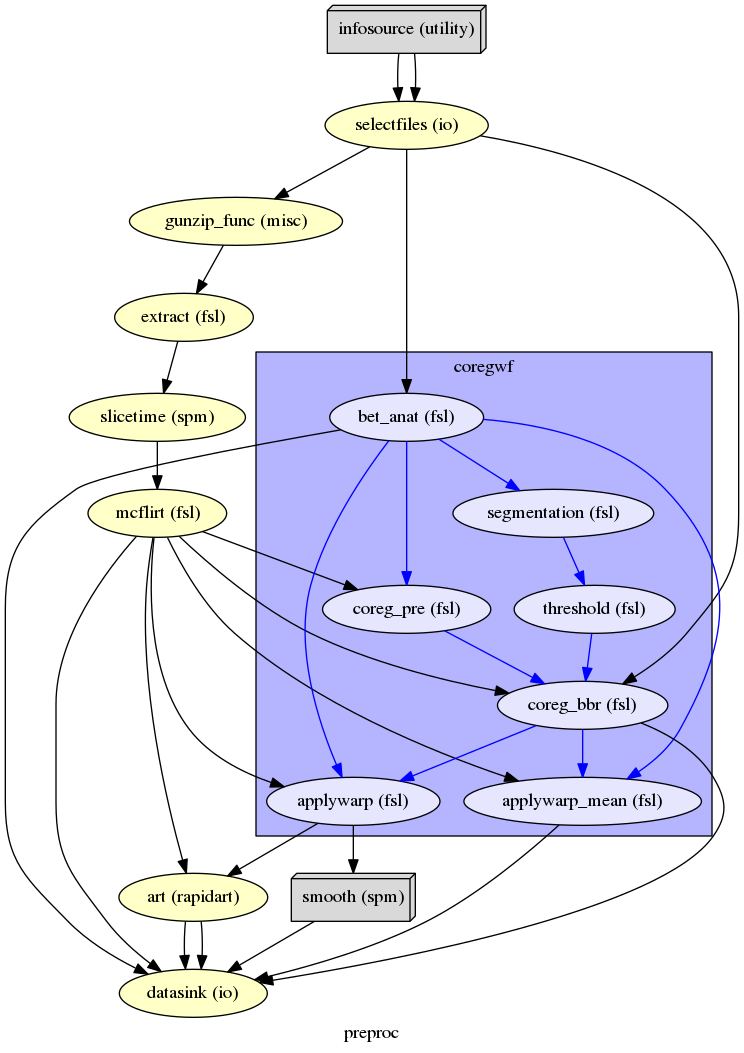

In [19]:
# Create preproc output graph# Creat # Create 
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

# Visualize the graph
from IPython.display import Image
Image(filename=opj(preproc.base_dir, 'preproc', 'graph.png'))

180928-19:14:46,948 nipype.workflow INFO:
	 Generated workflow graph: /data/wellbeing_analysis/workingdir/preproc/graph.png (graph2use=flat, simple_form=True).


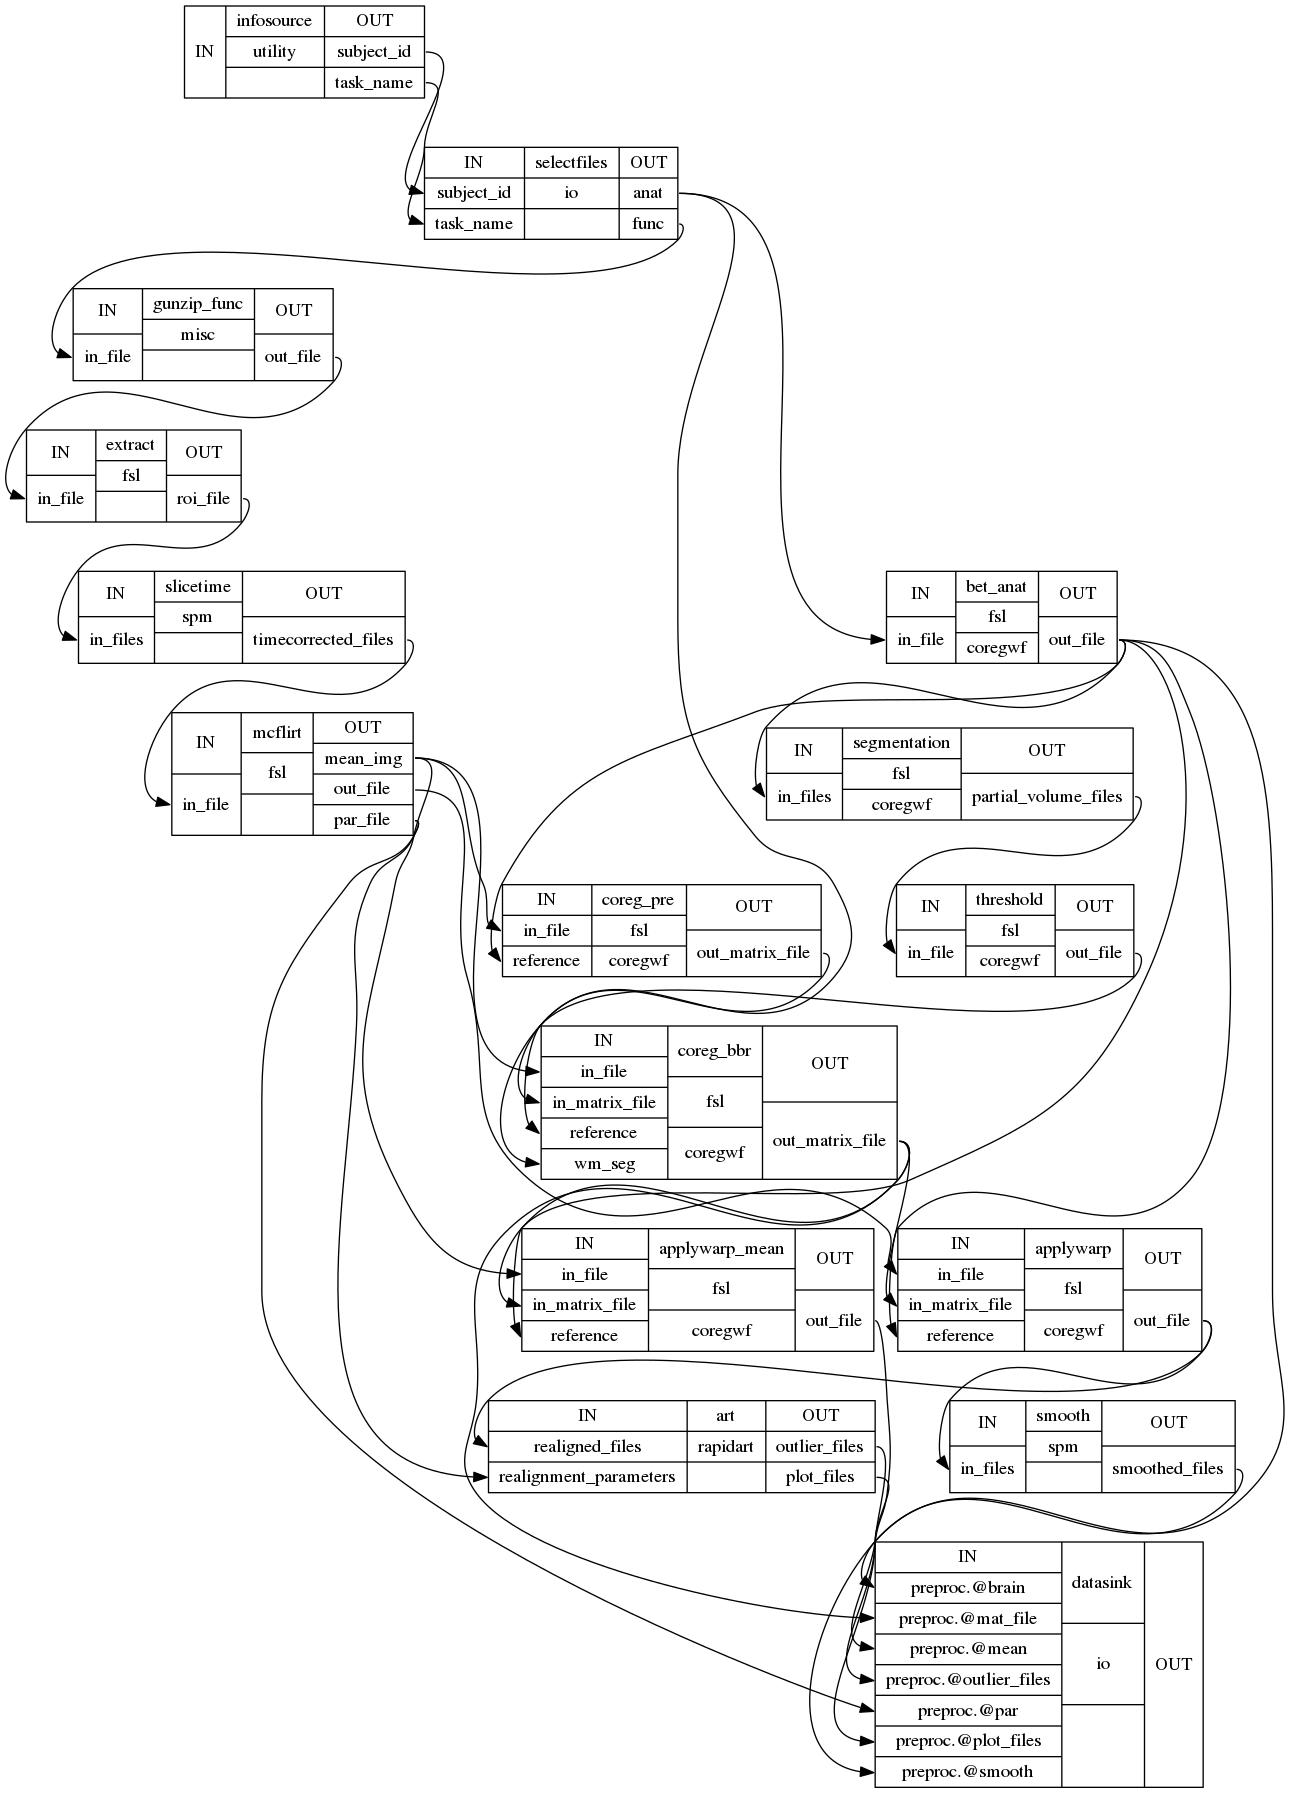

In [20]:
# Visualize the detailed graph# Visua # Visual 
preproc.write_graph(graph2use='flat', format='png', simple_form=True)
Image(filename=opj(preproc.base_dir, 'preproc', 'graph_detailed.png'))

In [ ]:
preproc.run('MultiProc', plugin_args={'n_procs': 10})

180928-19:15:05,565 nipype.workflow INFO:
	 Workflow preproc settings: ['check', 'execution', 'logging', 'monitoring']
180928-19:15:18,563 nipype.workflow INFO:
	 Running in parallel.
180928-19:15:18,950 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 498 jobs ready. Free memory (GB): 113.22/113.22, Free processors: 10/10.
180928-19:15:19,224 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/data/wellbeing_analysis/workingdir/preproc/_subject_id_3140_task_name_affect/selectfiles".180928-19:15:19,224 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/data/wellbeing_analysis/workingdir/preproc/_subject_id_3140_task_name_tom/selectfiles".

180928-19:15:19,227 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/data/wellbeing_analysis/workingdir/preproc/_subject_id_2653_task_name_tom/selectfiles".180928-19:15:19,230 nipype.workflow INFO:
	 [Node] Setting-up "preproc.selectfiles" in "/data/wellbeing_analysis/workingdir/preproc/_

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line

180928-19:24:16,388 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
180928-19:24:17,445 nipype.workflow INFO:
	 [Job 14] Completed (preproc.art).
180928-19:24:17,487 nipype.workflow INFO:
	 [MultiProc] Running 9 tasks, and 493 jobs ready. Free memory (GB): 103.82/113.22, Free processors: 1/10.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.segmentation
180928-19:24:17,700 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.applywarp_mean" in "/data/wellbeing_analysis/workingdir/preproc/coregwf/_subject_id_2677_task_name_affect/applywarp_mean".
180928-19:24:

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line

180928-19:25:22,363 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
180928-19:25:23,517 nipype.workflow INFO:
	 [Job 48] Completed (preproc.art).
180928-19:25:23,573 nipype.workflow INFO:
	 [MultiProc] Running 9 tasks, and 494 jobs ready. Free memory (GB): 107.62/113.22, Free processors: 1/10.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.coreg_bbr
180928-19:25:23,741 nipype.workflow INFO:
	 [Node] Setting-up "preproc.art" in "/data/wellbeing_analysis/workingdir/preproc/_subject_id_3140_task_name_affect/art".
180928-19:25:23,748 nipype.workflow INFO:
	 [Node] Running "art" ("nipype.algorithms.ra

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line

180928-19:25:32,325 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
180928-19:25:33,527 nipype.workflow INFO:
	 [Job 82] Completed (preproc.art).
180928-19:25:33,583 nipype.workflow INFO:
	 [MultiProc] Running 9 tasks, and 490 jobs ready. Free memory (GB): 107.62/113.22, Free processors: 1/10.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.coreg_bbr
180928-19:25:33,750 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.threshold" in "/data/wellbeing_analysis/workingdir/preproc/coregwf/_subject_id_3043_task_name_tom/threshold".
180928-19:25:33,754 nipype.workflow INFO:
	 [Node] Running "th

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line

180928-19:26:40,467 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
180928-19:26:41,225 nipype.workflow INFO:
	 [Node] Finished "preproc.coregwf.coreg_bbr".
180928-19:26:41,578 nipype.workflow INFO:
	 [Job 128] Completed (preproc.coregwf.coreg_bbr).
180928-19:26:41,591 nipype.workflow INFO:
	 [Job 99] Completed (preproc.art).
180928-19:26:41,633 nipype.workflow INFO:
	 [MultiProc] Running 8 tasks, and 492 jobs ready. Free memory (GB): 104.02/113.22, Free processors: 2/10.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.mcflirt
                       * preproc.slicetime
                       * preproc.slicetime
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.segmentation
180928-19:26:41,773 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.applywarp_mean" in "/data/wellb

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line

180928-19:27:14,561 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
180928-19:27:15,625 nipype.workflow INFO:
	 [Job 133] Completed (preproc.art).
180928-19:27:15,695 nipype.workflow INFO:
	 [MultiProc] Running 9 tasks, and 489 jobs ready. Free memory (GB): 103.82/113.22, Free processors: 1/10.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.mcflirt
                       * preproc.mcflirt
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.segmentation
180928-19:27:15,846 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.segmentation" in "/data/wellbeing_analysis/workingdir/preproc/coregwf/_subject_id_2684_task_name_affect/segmentation".
180928-19:27:15,855 nipype.workflow INFO:
	 [Node] Running

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line

180928-19:31:46,860 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
180928-19:31:47,863 nipype.workflow INFO:
	 [Job 167] Completed (preproc.art).
180928-19:31:47,903 nipype.workflow INFO:
	 [MultiProc] Running 9 tasks, and 482 jobs ready. Free memory (GB): 92.42/113.22, Free processors: 1/10.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.segmentation
180928-19:31:48,66 nipype.workflow INFO:
	 [Node] Setting-up "preproc.extract" in "/data/wellbeing_analysis/workingdir/preproc/_subject_id_2661_task_name_tom/extract".
180928-19:31:48,72 nipype.workflow INF

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line

180928-19:34:40,860 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
180928-19:34:42,31 nipype.workflow INFO:
	 [Job 201] Completed (preproc.art).
180928-19:34:42,109 nipype.workflow INFO:
	 [MultiProc] Running 9 tasks, and 481 jobs ready. Free memory (GB): 100.02/113.22, Free processors: 1/10.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.coregwf.segmentation
                       * preproc.smooth
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.segmentation
180928-19:34:42,321 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.threshold" in "/data/wellbeing_analysis/workingdir/preproc/coregwf/_subject_id_2607_task_name_affect/threshold".
180928-19:34:42,328 nipype.work

/home/zohyos7/anaconda3/lib/python3.6/site-packages/nipype/algorithms/rapidart.py:542: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/zohyos7/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/zohyos7/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line

180928-19:36:51,124 nipype.workflow INFO:
	 [Node] Finished "preproc.art".
180928-19:36:52,148 nipype.workflow INFO:
	 [Job 218] Completed (preproc.art).
180928-19:36:52,204 nipype.workflow INFO:
	 [MultiProc] Running 9 tasks, and 480 jobs ready. Free memory (GB): 100.02/113.22, Free processors: 1/10.
                     Currently running:
                       * preproc.smooth
                       * preproc.smooth
                       * preproc.coregwf.applywarp
                       * preproc.mcflirt
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.coreg_bbr
                       * preproc.coregwf.segmentation
                       * preproc.coregwf.segmentation
180928-19:36:52,370 nipype.workflow INFO:
	 [Node] Setting-up "preproc.coregwf.applywarp_mean" in "/data/wellbeing_analysis/workingdir/preproc/coregwf/_subject_id_2528_task_name_affect/applywarp_mean".
180928-19:36:52,380